## Generate dataset

Import packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,10)
%matplotlib inline
from astropy.modeling import models
from astropy.modeling import functional_models
from astropy import units as u
import os, json, random, cv2
from PIL import Image
from numpyencoder import NumpyEncoder

Global variables

In [2]:
wavelengths     = np.arange(400, 800)*u.nm
FWHM            = 0.5
lambda_Na       = 589.0*u.nm
lambda_Mg       = 518.3*u.nm
width           = 1000
height          = 1500

Define the function to generate the image. 

In [3]:
def add_background(image_3d):
    '''
    '''
    # TODO: mutate the background
    for i in range(400):
        image_3d[:,:,i] += int(30-0.06*i)
    return image_3d

def add_stars(image_3d, coord_stars, amp_stars, T_stars): 
    '''
    '''
    # psf
    PSF = functional_models.Gaussian2D(x_stddev=FWHM, y_stddev=FWHM)
    # draw N stars with radius FWHM/2
    for [x, y], amp_star, T_star in zip(coord_stars, amp_stars, T_stars): 
        # spectrum
        BB = models.BlackBody(temperature=T_star)
        # add star to the image
        radius = int(5*FWHM)
        xx = np.arange(-radius, radius+1)
        yy = np.arange(-radius, radius+1)
        XX, YY = np.meshgrid(xx, yy)
        star = np.repeat(PSF(XX, YY)[:,:,np.newaxis], 400, axis=2)*BB(wavelengths).value*amp_star
        star = star.astype('uint16')
        image_3d[x-radius:x+radius+1,y-radius:y+radius+1,:] += star
    return image_3d

def add_meteor(image_3d, coord_meteor, amp_meteor, T_meteor, dir_meteor, length_meteor): 
    '''
    '''
    # spectrum - continuous spectrum
    BB = models.BlackBody(temperature=T_meteor)
    meteor_x = BB(wavelengths).value*amp_meteor
    # spectrum - emission line
    amp_Na = amp_meteor*2e-6
    amp_Mg = amp_meteor*1e-6
    emission_Na = functional_models.Gaussian1D(mean=lambda_Na.value, stddev=FWHM)
    emission_Mg = functional_models.Gaussian1D(mean=lambda_Mg.value, stddev=FWHM)
    meteor_x += emission_Na(wavelengths.value)*amp_Na
    meteor_x += emission_Mg(wavelengths.value)*amp_Mg
    # trajectory
    meteor_y = np.arange(length_meteor)
    amplitude = 1e3
    # TODO: use true trajectory
    meteor_y = (meteor_y*10/length_meteor)**(0.1) - meteor_y/length_meteor
    meteor_y = meteor_y*amplitude
    meteor = np.outer(meteor_y, meteor_x)
    # draw meteor
    dx = np.cos(dir_meteor)
    dy = np.sin(dir_meteor)
    PSF = functional_models.Gaussian2D(x_stddev=FWHM, y_stddev=FWHM)
    for i in range(length_meteor): 
        radius = int(5*FWHM)
        x_plot = int(coord_meteor[0] + dx*i)
        y_plot = int(coord_meteor[1] + dy*i)
        xx = np.arange(-radius, radius+1)
        yy = np.arange(-radius, radius+1)
        XX, YY = np.meshgrid(xx, yy)
        star = np.repeat(PSF(XX, YY)[:,:,np.newaxis], 400, axis=2)*meteor[i, :]
        star = star.astype('uint16')
        image_3d[x_plot-radius:x_plot+radius+1,y_plot-radius:y_plot+radius+1,:] += star
    # plt.imshow(meteor)
    # plt.colorbar()
    # plt.show()


    # TODO: return the bounding box
    return image_3d

def add_landscape(image_3d): 
    '''
    TODO
    '''
    return image_3d

def capture(image_3d, direction, length): 
    '''
    '''
    dx = np.cos(direction)
    dy = np.sin(direction)
    for i in range(400): 
        # print(i, int(dx*length*i/400))
        image_3d[:,:,i] = np.roll(image_3d[:,:,i], axis=0, shift=int(dx*length*i/400))
        image_3d[:,:,i] = np.roll(image_3d[:,:,i], axis=1, shift=int(dy*length*i/400))
    image_rgb = np.zeros([width, height, 3], dtype=np.uint16)
    # RGB filter
    # TODO: adjust the RGB curve of camera
    # TODO: adjust the true slit distortion
    gaussian_r = functional_models.Gaussian1D(mean=600, stddev=30)
    gaussian_g = functional_models.Gaussian1D(mean=540, stddev=30)
    gaussian_b = functional_models.Gaussian1D(mean=480, stddev=30)
    filter_r = gaussian_r(wavelengths.value)
    filter_g = gaussian_g(wavelengths.value)
    filter_b = gaussian_b(wavelengths.value)
    filter_r[200:400] = 1-np.arange(200)**2/200**2
    # generate RGB components
    image_rgb[:, :, 0] = np.average(image_3d*filter_r, axis=2)
    image_rgb[:, :, 1] = np.average(image_3d*filter_g, axis=2)
    image_rgb[:, :, 2] = np.average(image_3d*filter_b, axis=2)
    image_rgb = image_rgb.astype('uint16')
    return image_rgb

def augmentation(image_rgb): 
    '''
    Add the lens effect such as disortion and gaussian noise
    TODO: use `imgaug`
    '''
    return image_rgb


def generate_image(coord_stars, amp_stars, T_stars, coord_meteor, amp_meteor, T_meteor, 
                    angle_meteor, length_meteor, angle_slit, length_slit): 
    '''
    function to generate the image. 
    Args: 
        The position of all the stars, the meteor, etc.: 
        coords_stars    [N, 2]      the coordinates of stars plotted in the diagram. Will also give the number of stars
        TODO...
        angle_slit      [0, 2pi)
        angle_meteor    [0, 2pi)
        length_meteor   int         how long the meteor is 
        length_slit     int         how long the track of spectrum is
    Return: 
        one RGB image
    '''
    image_3d = np.zeros([width, height, 400], dtype=np.uint16)           # 0-65536, valid in 0-256 TODO: change to float16? 
    image_3d = add_background(image_3d)
    image_3d = add_stars(image_3d, coord_stars, amp_stars, T_stars)
    image_3d = add_meteor(image_3d, coord_meteor, amp_meteor, T_meteor, angle_meteor, length_meteor)
    image_rgb = capture(image_3d, angle_slit, length_slit)
    image_rgb = augmentation(image_rgb)
    # clip the image
    image_rgb = np.clip(image_rgb, 0, 255)# including 0 and 255
    # image_rgb = image_rgb.astype('uint8')
    return image_rgb #image_3d[:,:,0]
    



Generate the dataset. 

generating image 1...
generating image 2...
generating image 3...
generating image 4...
generating image 5...
generating image 6...
generating image 7...
generating image 8...
generating image 9...
generating image 10...
generating image 11...
generating image 12...
generating image 13...
generating image 14...
generating image 15...
generating image 16...
generating image 17...
generating image 18...
generating image 19...
generating image 20...
generating image 21...
generating image 22...
generating image 23...
generating image 24...
generating image 25...
generating image 26...
generating image 27...
generating image 28...
generating image 29...
generating image 30...
generating image 31...
generating image 32...
generating image 33...
generating image 34...
generating image 35...
generating image 36...
generating image 37...
generating image 38...
generating image 39...
generating image 40...
generating image 41...
generating image 42...
generating image 43...
generating image 44.

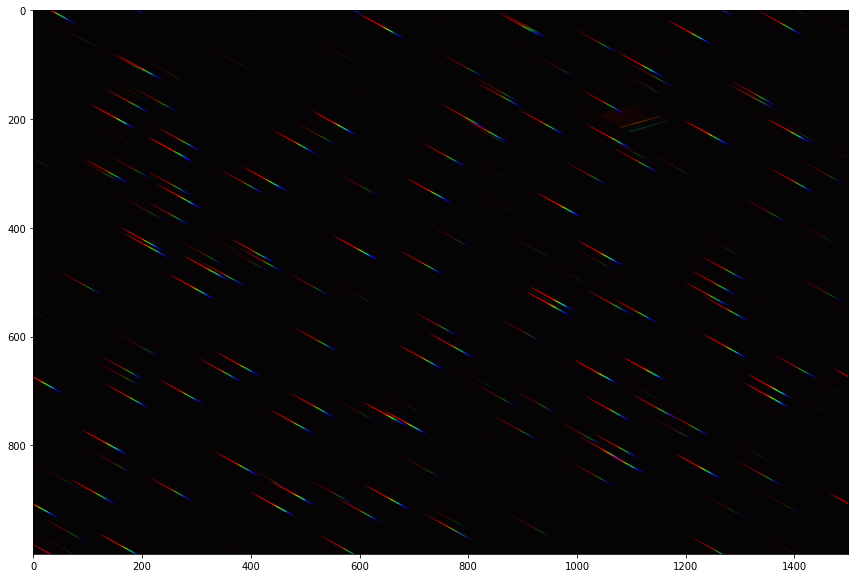

In [17]:
def generate_dataset(num_images, dir='./dataset/'): 
    '''
    generate the image and save the images in the directory. 
    Args: 
        num_images  
        dir
    Output: 
        JPG files and a json file in COCO format in the directory
    No return
    NOTE: returns an image for testing
    '''
    # TODO: check if the directory is usable
    # customized variables applying to all images
    annotation_id = 1
    labels = {
        'info': {
            'description': 'Meteor spectrum fake data',
            'url': 'https://cheysen.fit',
            'version': '0.1',
            'year': 2023,
            'contributor': 'Yichen Liu',
            'date_created': '2023/02/08'
        },
        'licenses': {
            'url': 'NaN',
            'id': 1,
            'name': 'NaN'
        },
        'images': [],
        'annotations': [],
        'categories': [{
                'id': 1,
                'name': 'meteor',
                'keypoints': [
                    'start_Na',
                    'end_Na',
                    'start_Mg',
                    'end_Mg',
                ],
                'skeleton': [
                    [1, 2],
                    [3, 4],
                ]
            },{
                'id': 2,
                'name': 'star',
                'keypoints': [
                    'start_star',
                    'end_star',
                    'start_', 
                    'end_'
                ],
                'skeleton': [
                    [1, 2],
                ]
            }
        ]
    }
    for image_id in range(1, num_images+1): 
        print('generating image %d...'%image_id)
        # parameters
        num_stars       = 200
        x_stars         = (np.random.rand(num_stars)*(width-10*FWHM)+5*FWHM).astype(np.int16)
        y_stars         = (np.random.rand(num_stars)*(height-10*FWHM)+5*FWHM).astype(np.int16)
        # TODO: change the border where the meteor can show
        length_meteor   = int(np.random.rand()*500)                      # pixel
        x_meteor        = int(np.random.rand()*(width-2*length_meteor)+length_meteor)
        y_meteor        = int(np.random.rand()*(height-2*length_meteor)+length_meteor)
        # image - parameters needed for `generate_image` function
        coord_stars     = np.array([x_stars, y_stars]).T            # [N, 2]pixel
        amp_stars       = np.random.rand(num_stars)*1e8             # [N]erg -> pixel value
        T_stars         = (np.random.rand(num_stars)*15000+5000)*u.K# [N]5000K-20000K
        coord_meteor    = [x_meteor, y_meteor]
        amp_meteor      = np.random.rand()*1e8
        T_meteor        = 2000*u.K
        angle_meteor    = np.random.rand()*2*np.pi                  # radian
        # length_meteor   = int(np.random.rand()*500)                 # pixel
        angle_slit      = np.random.rand()*2*np.pi                  # radian
        length_slit     = 100
        # image
        image = generate_image(coord_stars, amp_stars, T_stars, coord_meteor, amp_meteor, T_meteor, 
                                angle_meteor, length_meteor, angle_slit, length_slit)
        image8 = image.astype(np.uint8)-1
        im = Image.fromarray(image8)
        im.save(os.path.join(dir, '%d.jpg'%image_id), quality=100)
        # label - image
        label_image = {
            'license': 1,
            'file_name': '%d.jpg'%image_id,
            'height': width,
            'width': height,
            'id': image_id
        }
        labels['images'].append(label_image)
        # label - annotation - meteor
        bbox_x1      = int(min(
            x_meteor, 
            x_meteor + np.cos(angle_slit)*length_slit, 
            x_meteor + np.cos(angle_meteor)*length_meteor, 
            x_meteor + np.cos(angle_slit)*length_slit + np.cos(angle_meteor)*length_meteor, 
        ))
        bbox_y1      = int(min(
            y_meteor, 
            y_meteor + np.sin(angle_slit)*length_slit, 
            y_meteor + np.sin(angle_meteor)*length_meteor, 
            y_meteor + np.sin(angle_slit)*length_slit + np.sin(angle_meteor)*length_meteor, 
        ))
        bbox_x2      = int(max(
            x_meteor, 
            x_meteor + np.cos(angle_slit)*length_slit, 
            x_meteor + np.cos(angle_meteor)*length_meteor, 
            x_meteor + np.cos(angle_slit)*length_slit + np.cos(angle_meteor)*length_meteor, 
        ))
        bbox_y2      = int(max(
            y_meteor, 
            y_meteor + np.sin(angle_slit)*length_slit, 
            y_meteor + np.sin(angle_meteor)*length_meteor, 
            y_meteor + np.sin(angle_slit)*length_slit + np.sin(angle_meteor)*length_meteor, 
        ))
        bbox_w      = bbox_x2 - bbox_x1
        bbox_h      = bbox_y2 - bbox_y1
        start_Na_x  = int(x_meteor + np.cos(angle_slit)*length_slit*(lambda_Na.value-400)/400)
        start_Na_y  = int(y_meteor + np.sin(angle_slit)*length_slit*(lambda_Na.value-400)/400)
        end_Na_x    = int(start_Na_x + np.cos(angle_meteor)*length_meteor)
        end_Na_y    = int(start_Na_y + np.sin(angle_meteor)*length_meteor)
        start_Mg_x  = int(x_meteor + np.cos(angle_slit)*length_slit*(lambda_Mg.value-400)/400)
        start_Mg_y  = int(y_meteor + np.sin(angle_slit)*length_slit*(lambda_Mg.value-400)/400)
        end_Mg_x    = int(start_Mg_x + np.cos(angle_meteor)*length_meteor)
        end_Mg_y    = int(start_Mg_y + np.sin(angle_meteor)*length_meteor)
        label_meteor = {
            'id': annotation_id, 
            'image_id': image_id,
            'category_id': 1,
            'bbox': [
                bbox_y1, bbox_x1, bbox_h, bbox_w
            ],
            'keypoints': [
                start_Na_y, start_Na_x, 2, end_Na_y, end_Na_x, 2, 
                start_Mg_y, start_Mg_x, 2, end_Mg_y, end_Mg_x, 2
            ], 
            'num_keypoints': 4
        }
        labels['annotations'].append(label_meteor)
        annotation_id += 1
        # label - annotation - stars
        for x, y in coord_stars: 
            start_star_x    = x
            start_star_y    = y
            end_star_x      = int(x + np.cos(angle_slit)*length_slit)
            end_star_y      = int(y + np.sin(angle_slit)*length_slit)
            bbox_x1 = min(start_star_x, end_star_x)
            bbox_y1 = min(start_star_y, end_star_y)
            bbox_x2 = max(start_star_x, end_star_x)
            bbox_y2 = max(start_star_y, end_star_y)
            bbox_w      = bbox_x2 - bbox_x1
            bbox_h      = bbox_y2 - bbox_y1
            # check if the star is valid for labelling
            if 0<=end_star_x and end_star_x<width and 0<=end_star_y and end_star_y<height: 
                label_star = {
                    'id': annotation_id, 
                    'image_id': image_id,
                    'category_id': 2,
                    'bbox': [
                        bbox_y1, bbox_x1, bbox_h, bbox_w
                    ],
                    'keypoints': [
                        start_star_y, start_star_x, 2, end_star_y, end_star_x, 2, 0, 0, 0, 0, 0, 0
                    ], 
                    'num_keypoints': 2
                }
                labels['annotations'].append(label_star)
                annotation_id += 1
    # save json file
    with open(os.path.join(dir, 'labels.json'), 'w') as f:
        json.dump(labels, f, sort_keys=False, indent=2, separators=(',', ': '), cls=NumpyEncoder)
    
    return image, labels

dir='./dataset/'
num_images = 100
image, labels = generate_dataset(num_images, dir)

plt.figure(figsize=[15, 10])
plt.imshow(image)

## Register the data

Try to read the dataset we have just generated and confirm that the data is correctly loaded and labelled 

In [1]:
from detectron2.data import DatasetCatalog
from detectron2.data import MetadataCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.utils.visualizer import Visualizer

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.modeling import models
from astropy.modeling import functional_models
from astropy import units as u
import os, json, random, cv2
from PIL import Image
from numpyencoder import NumpyEncoder

dir='./dataset/'

register_coco_instances('fake_meteors', {}, os.path.join(dir, 'labels.json'), dir)

(1000, 1500, 3)


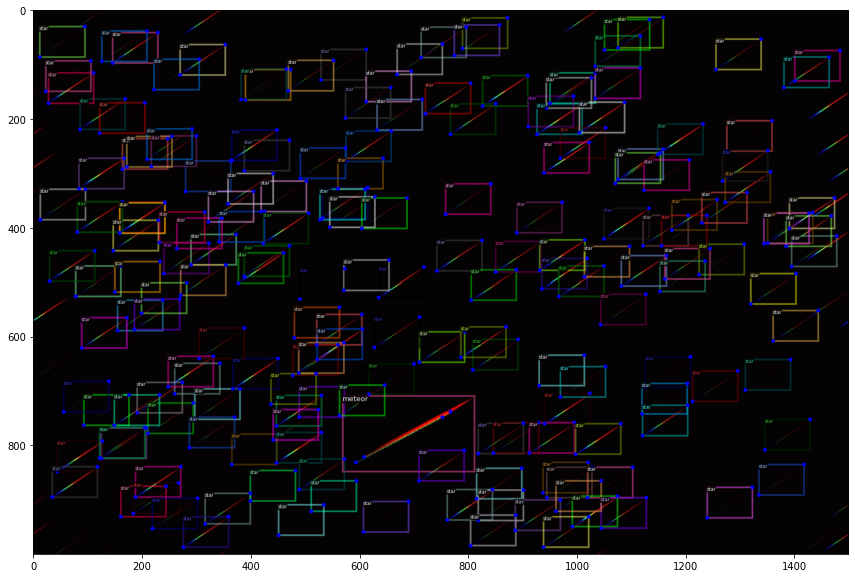

In [2]:

dataset_dicts = DatasetCatalog.get('fake_meteors')
metadata = MetadataCatalog.get('fake_meteors')

for d in random.sample(dataset_dicts, 1):
    img = plt.imread(d["file_name"])
    print(img.shape)
    visualizer = Visualizer(img[:, :, ::-1], metadata=metadata, scale=1)
    out = visualizer.draw_dataset_dict(d)
    plt.figure(figsize=[15, 10])
    plt.imshow(out.get_image()[:, :, ::-1])


## Train

Using `R50-FPN	3x` model in `COCO Person Keypoint Detection Baselines with Keypoint R-CNN` 

In [3]:
from detectron2.engine import DefaultTrainer
from detectron2 import model_zoo
from detectron2.config import get_cfg

MetadataCatalog.get("fake_meteors").keypoint_names = ['0', '1', '2', '3']
MetadataCatalog.get("fake_meteors").keypoint_flip_map = []
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("fake_meteors",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 1
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2  # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.00001  # pick a good LR
cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64   # The "RoIHead batch size". 128 is faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.


# cfg.MODEL.ROI_KEYPOINT_HEAD.NUM_KEYPOINTS = 3
# cfg.TEST.KEYPOINT_OKS_SIGMAS = np.ones((3, 1), dtype=float).tolist()

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[02/10 08:05:56 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (2, 1024) in the checkpoint but (3, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (2,) in the checkpoint but (3,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (4, 1024) in the checkpoint but (8, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (4,) in the checkpoint but (8,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


[02/10 08:05:56 d2.engine.train_loop]: Starting training from iteration 0
[02/10 08:06:04 d2.utils.events]:  eta: 0:10:06  iter: 19  total_loss: 16.14  loss_cls: 1.058  loss_box_reg: 0.05357  loss_keypoint: 6.921  loss_rpn_cls: 7.284  loss_rpn_loc: 0.5349  time: 0.2062  data_time: 0.0736  lr: 1.9981e-05  max_mem: 3222M
[02/10 08:06:08 d2.utils.events]:  eta: 0:10:05  iter: 39  total_loss: 9.957  loss_cls: 0.9546  loss_box_reg: 0.341  loss_keypoint: 6.965  loss_rpn_cls: 1.214  loss_rpn_loc: 0.3678  time: 0.2013  data_time: 0.0063  lr: 3.9961e-05  max_mem: 3222M
[02/10 08:06:12 d2.utils.events]:  eta: 0:10:00  iter: 59  total_loss: 9.073  loss_cls: 0.806  loss_box_reg: 0.4338  loss_keypoint: 6.818  loss_rpn_cls: 0.3461  loss_rpn_loc: 0.3092  time: 0.2022  data_time: 0.0056  lr: 5.9941e-05  max_mem: 3228M
[02/10 08:06:16 d2.utils.events]:  eta: 0:09:56  iter: 79  total_loss: 8.768  loss_cls: 0.6688  loss_box_reg: 0.4244  loss_keypoint: 7  loss_rpn_cls: 0.2116  loss_rpn_loc: 0.2455  time: 

KeyboardInterrupt: 

In [10]:
from detectron2.engine import DefaultPredictor

for d in random.sample(dataset_dicts, 1):    
    im = plt.imread(d["file_name"])
    predictor = DefaultPredictor(cfg)
    outputs = predictor(im)
    v = Visualizer(im[:,:,::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize=[15, 10])
    plt.imshow(out.get_image()[:, :, ::-1])

RuntimeError: CUDA error: unspecified launch failure
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

# Evaluation

See how it works in our validation dataset (TODO) and the real image

IndexError: list index out of range

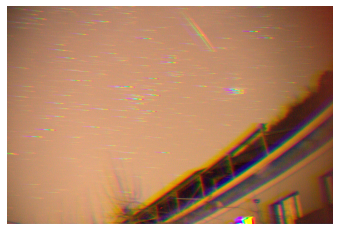

In [5]:
import rawpy

path = '../01/IMG_0241.CR2'
with rawpy.imread(path) as raw:
    rgb = raw.postprocess(output_bps=16)
    rgb_show = raw.postprocess(output_bps=8)

plt.figure()
plt.imshow(rgb_show, cmap=plt.cm.gray)
plt.axis('off')
outputs = predictor(rgb_show)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.imshow(out.get_image()[:, :, ::-1])

In [10]:
metadata

namespace(name='fake_meteors',
          json_file='./dataset/labels.json',
          image_root='./dataset/',
          evaluator_type='coco',
          thing_classes=['meteor', 'star'],
          thing_dataset_id_to_contiguous_id={1: 0, 2: 1},
          keypoint_names=['meteor', 'star'],
          keypoint_flip_map=[])